In [32]:
# Name: Sai Anish Garapati
# UIN: 650208577

In [33]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
import shutil
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as Image

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(12544, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 43)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

        '''x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x'''

In [35]:
def train_model(device, model, train_loader, optimizer, epoch, batch_size):
    model.train()
    tot_loss = 0
    correct = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, label)
        loss.backward()
        optimizer.step()

        predictions = output.argmax(dim=1, keepdim=True)
        correct += predictions.eq(label.view_as(predictions)).sum().item()
        tot_loss += loss.item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100.0 * batch_idx / len(train_loader), tot_loss / (batch_idx + 1),
                100.0 * correct / ((batch_idx + 1) * batch_size)))
    print('End of Epoch: {}'.format(epoch))
    print('Training Loss: {:.6f}, Training Accuracy: {:.2f}%'.format(
        tot_loss / len(train_loader), 100.0 * correct / (len(train_loader) * batch_size)))

    return tot_loss / len(train_loader), 100.0 * correct / (len(train_loader) * batch_size)


In [36]:
def validation_model(device, model, validation_loader, batch_size):
    model.eval()
    tot_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(validation_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            tot_loss += torch.nn.CrossEntropyLoss()(output, label).item()
            predictions = output.argmax(dim=1, keepdim=True)
            # print(predictions, label.view_as(predictions))
            correct += predictions.eq(label.view_as(predictions)).sum().item()

    # print(correct, len(validation_loader) * batch_size, (batch_idx + 1) * batch_size)

    print('Validation Loss: {:.6f}, Validation Accuracy: {:.2f}%'.format(
        tot_loss / len(validation_loader),
        100.0 * correct / (len(validation_loader) * batch_size)
    ))

    return tot_loss/len(validation_loader), 100.0 * correct / (len(validation_loader) * batch_size)


Train Epoch: 1 [0/33327 (0%)]	Loss: 3.759278, Accuracy: 0.78%
Train Epoch: 1 [12800/33327 (38%)]	Loss: 2.626584, Accuracy: 27.17%
Train Epoch: 1 [25600/33327 (77%)]	Loss: 1.824681, Accuracy: 47.56%
End of Epoch: 1
Training Loss: 1.546092, Training Accuracy: 55.07%
Validation Loss: 0.403512, Validation Accuracy: 87.47%
Train Epoch: 2 [0/33327 (0%)]	Loss: 0.447363, Accuracy: 89.06%
Train Epoch: 2 [12800/33327 (38%)]	Loss: 0.422045, Accuracy: 87.36%
Train Epoch: 2 [25600/33327 (77%)]	Loss: 0.381274, Accuracy: 88.66%
End of Epoch: 2
Training Loss: 0.355950, Training Accuracy: 89.12%
Validation Loss: 0.154395, Validation Accuracy: 93.85%
Train Epoch: 3 [0/33327 (0%)]	Loss: 0.161721, Accuracy: 94.53%
Train Epoch: 3 [12800/33327 (38%)]	Loss: 0.215455, Accuracy: 93.62%
Train Epoch: 3 [25600/33327 (77%)]	Loss: 0.205774, Accuracy: 93.87%
End of Epoch: 3
Training Loss: 0.198410, Training Accuracy: 93.88%
Validation Loss: 0.111120, Validation Accuracy: 95.32%
Train Epoch: 4 [0/33327 (0%)]	Loss: 0.

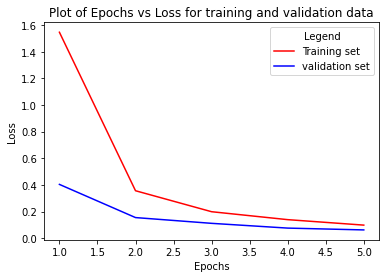

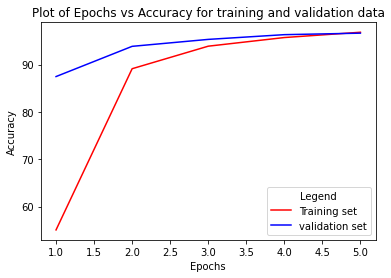

In [37]:
if __name__ == '__main__':
    train_path = '../../../../ML_Project_data/Train/'
    test_path = '../../../../ML_Project_data/Test/'

    label_map = []

    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.RandomCrop(32),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
    test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)

    train_len = int(0.85 * len(train_dataset))
    validation_len = len(train_dataset) - train_len

    train_data, validation_data = torch.utils.data.random_split(train_dataset, [train_len, validation_len])

    torch.manual_seed(2021)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    # test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
    validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=500, shuffle=True)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.8)

    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    for epoch in range(0, 5):
        loss, accuracy = train_model(device, model, train_loader, optimizer, epoch + 1, 128)
        training_loss.append(loss)
        training_accuracy.append(accuracy)

        loss, accuracy = validation_model(device, model, validation_loader, 500)
        validation_loss.append(loss)
        validation_accuracy.append(accuracy)

        scheduler.step()

    %matplotlib inline
    plt.title('Plot of Epochs vs Loss for training and validation data')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(list(range(1, len(training_loss) + 1)), training_loss, 'r', label='Training set')
    plt.plot(list(range(1, len(validation_loss) + 1)), validation_loss, 'b', label='validation set')
    plt.legend(title='Legend')
    plt.show()

    plt.title('Plot of Epochs vs Accuracy for training and validation data')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(list(range(1, len(training_loss) + 1)), training_accuracy, 'r', label='Training set')
    plt.plot(list(range(1, len(validation_loss) + 1)), validation_accuracy, 'b', label='validation set')
    plt.legend(title='Legend')

    plt.show()

    torch.save(model.state_dict(), 'ML_Model.pt')
